In [1]:
"""
Python 3.9.2
pip freeze 

appdirs==1.4.4
asgiref==3.3.4
autopep8==1.5.5
boto3==1.17.49
botocore==1.20.49
certifi==2020.12.5
cycler==0.10.0
distlib==0.3.1
Django==3.2
django-environ==0.4.5
filelock==3.0.12
jmespath==0.10.0
joblib==1.0.1
kiwisolver==1.3.1
matplotlib==3.3.4
numpy==1.20.1
pandas==1.2.4
Pillow==8.1.0
pipenv==2020.11.15
pycodestyle==2.7.0
pyparsing==2.4.7
PyQt5==5.15.4
PyQt5-Qt5==5.15.2
PyQt5-sip==12.8.1
python-dateutil==2.8.1
python-dotenv==0.17.0
pytz==2021.1
s3transfer==0.3.6
scikit-learn==0.24.1
scipy==1.6.1
six==1.15.0
sklearn==0.0
sqlparse==0.4.1
threadpoolctl==2.1.0
toml==0.10.2
urllib3==1.26.4
virtualenv==20.4.4
virtualenv-clone==0.5.4
"""

'\nPython 3.9.2\npip freeze \n\nappdirs==1.4.4\nasgiref==3.3.4\nautopep8==1.5.5\nboto3==1.17.49\nbotocore==1.20.49\ncertifi==2020.12.5\ncycler==0.10.0\ndistlib==0.3.1\nDjango==3.2\ndjango-environ==0.4.5\nfilelock==3.0.12\njmespath==0.10.0\njoblib==1.0.1\nkiwisolver==1.3.1\nmatplotlib==3.3.4\nnumpy==1.20.1\npandas==1.2.4\nPillow==8.1.0\npipenv==2020.11.15\npycodestyle==2.7.0\npyparsing==2.4.7\nPyQt5==5.15.4\nPyQt5-Qt5==5.15.2\nPyQt5-sip==12.8.1\npython-dateutil==2.8.1\npython-dotenv==0.17.0\npytz==2021.1\ns3transfer==0.3.6\nscikit-learn==0.24.1\nscipy==1.6.1\nsix==1.15.0\nsklearn==0.0\nsqlparse==0.4.1\nthreadpoolctl==2.1.0\ntoml==0.10.2\nurllib3==1.26.4\nvirtualenv==20.4.4\nvirtualenv-clone==0.5.4\n'

In [3]:
import numpy as np
from numpy.random import rand, randint
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.sparse import data
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import classification_report, confusion_matrix
from typing import Union
from scipy.spatial.distance import mahalanobis
FILE_DIR = os.path.abspath('')
TRAIN_FILE_PATH = os.path.join(FILE_DIR, "..", "baza_danych", "avila-tr.txt")
TEST_FILE_PATH = os.path.join(FILE_DIR, "..", "baza_danych", "avila-ts.txt")
COLUMN_NAMES = ["Intercolumnar distance", "Upper margin", "Lower margin", "Exploitation", "Row number", "Modular ratio", "Interlinear spacing", "Weight", "Peak number", "Modular ratio/Interlinear spacing", "Class"]
CLASS_NAMES = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "W", "X", "Y"]
ATTRIBUTE_NAMES = ["Intercolumnar distance", "Upper margin", "Lower margin", "Exploitation", "Row number", "Modular ratio", "Interlinear spacing", "Weight", "Peak number", "Modular ratio/Interlinear spacing"]



In [6]:
class Dataset():
    def __init__(self, train_file:str, test_file:str, limit_to_classes:list = CLASS_NAMES, limit_to_attributes=ATTRIBUTE_NAMES, train_test_split_ratio:float=None, normalize:bool=False):
        """Klasa pomocnicza do obsługi zbioru

        Args:
            train_file (str): Ścieżka do zbioru treningowego.
            test_file (str): Ścieżka do zbioru testowego.
            limit_to_classes (list[str], optional): Ograniczenie klas, lista klas które mają być brane pod uwagę.
                Próbki spoza tej listy zostaną usuniętę zarówno w zbiorze testowym jak i treningowym. Domyślnie CLASS_NAMES(wszystkie klasy).
            limit_to_attributes (Union[list,int], optional): Ograniczenie cech. Lista nazw cech do wzięcia pod uwagę. 
                Możliwe jest także podanie liczby całkowitej n w wyniku czego automatycznie wybrane zostanie n najlepszych cech korzystając z sklearn SelectKBest.
                Domyślnie ATTRIBUTE_NAMES(wszystkie cechy).
            train_test_split_ratio (float, optional): Ułamek według którego podzielić połączony oryginalny zbiór treningowy na testowy, do testowania skuteczności algorytmów.
                Domyślnie None umieszcza w self.train cały zbiór treningowy i w self.test cały zbiór testowy
            normalize (bool, optional): Czy normalizować za pomocą min-max próbki. 
                Próbki znormalizowane są Z-normalizacją, więc prawdopodobnie nie jest to konieczne. Domyślnie False.

        Raises:
            Exception: [description]
        """
        # wczytuje zbiory z .csv
        self.train = pd.read_csv(train_file, header=None)
        self.test = pd.read_csv(test_file, header=None)
        print(f"Loaded {self.train.shape} train dataset from file {train_file}.")
        print(f"Loaded {self.test.shape} test dataset from file {test_file}.")

        # łączy zbiory testowy i treningowy w jeden jeśli mają one być przeliczone
        self.combined = pd.concat((self.train, self.test), axis=0) 
        self.combined.reset_index(drop=True, inplace=True) # reset indeksowania
        print(f"Combined test and train into {self.combined.shape}.")
        combined_len = self.combined.shape[0]

        # jeśli split_ratio podano należy przetasować zbiory i podzielić na nowo
        if(train_test_split_ratio is not None):
            if(train_test_split_ratio >= 1 or train_test_split_ratio <= 0): raise Exception("Split ratio must be between (0,1).")
            # punkt podziału zbiorów na treningowy i testowy
            # zbiory dzielimy i resetujemy indeksy
            split_point = int(self.train.shape[0]*train_test_split_ratio)
            self.train = self.train[:split_point]
            self.test = self.train[split_point:]
            self.train.reset_index(drop=True, inplace=True)
            self.test.reset_index(drop=True, inplace=True)
            print(f"Train set was split into {self.train.shape}. Test set was split into {self.test.shape}.")
        else:
            print("Preserving original test-train split.")

        # nadaj kolumnom nazwy
        self.combined.columns = COLUMN_NAMES
        self.train.columns = COLUMN_NAMES
        self.test.columns = COLUMN_NAMES

        self.remove_weird_samples()

        if(normalize): 
            self.normalize()

        # usuń ze zbioru próbki z nieanalizowanych klas i pomijane atrybuty
        self.preserved_classes = limit_to_classes
        self.preserved_attributes = limit_to_attributes
        self.reduce_classes(limit_to_classes)
        self.reduce_attributes()
        
        # stwórz słownik z próbkami każdej z klas
        self.class_split()
        # policz ich centroidy
        self.compute_means()
        # policz ich macierze kowariancji
        self.compute_covariance_matrices()

    def remove_weird_samples(self):
        self.train = self.train[self.train['Peak number'] < 10] # jedna próbka ma wartość >40 wiec prawdopodobnie jest błędna

    def normalize(self): # nie normalizuje self.combined
        maxes = self.combined.max(axis=0)
        mins = self.combined.min(axis=0)
        span = maxes[:-1] - mins[:-1] # wszystkie poza ostatnią kolumną, zawierającą litere klasy

        for col in range(self.train.shape[1] - 1): # -1 aby nie minmaxowac klasy
            self.train.iloc[:,col] = self.train.iloc[:,col].subtract(mins[col]).divide(span[col])
        for col in range(self.test.shape[1] - 1):
            self.test.iloc[:,col] = self.test.iloc[:,col].subtract(mins[col]).divide(span[col])

    def reduce_classes(self, preserved:list):
        """Odrzuca wszystkie próbki niepochodzące z klas podanych w liście preserved

        Args:
            preserved (lst[str]): lista klas do zachowania.
        """
        self.combined = self.combined[self.combined["Class"].isin(preserved)]
        self.train = self.train[self.train["Class"].isin(preserved)]
        self.test = self.test[self.test["Class"].isin(preserved)]
        self.combined.reset_index(drop=True, inplace=True)
        self.train.reset_index(drop=True, inplace=True)
        self.test.reset_index(drop=True, inplace=True)

    def reduce_attributes(self):
        """ Usuwa cechy(kolumny) niezawarte w self.preserved_attributes ze zbiorów testowego i treningowego
            Jeśli self.preserved_attributes jest liczbą to wyznacza najlepsze cechy za pomocą SelectKBest
        """
        if(type(self.preserved_attributes) is int):
            # <------------------------------>
            selector = SelectKBest(f_classif, k=self.preserved_attributes) # <-------------------- jak działa f_classif
            # <------------------------------>
            attrs_new = selector.fit_transform(self.train.iloc[:,:-1], self.train.iloc[:,-1])
            self.preserved_attributes = self.train.columns[:-1][selector.get_support()]
            print(f"Reduced attributes to {self.preserved_attributes} using SelectKBest")
            #self.train = attrs_new.concat(self.train.iloc[:,-1], axis=1)
            pass
        to_drop = [attr for attr in ATTRIBUTE_NAMES if attr not in self.preserved_attributes]
        self.combined.drop(to_drop, axis=1, inplace=True)
        self.train.drop(to_drop, axis=1, inplace=True)
        self.test.drop(to_drop, axis=1, inplace=True)
    
    def class_split(self):
        """Tworzy słownik dzielący próbki ze zbioru treningowego na klasy
            klasa:próbki
        """
        self.classed = {}
        for cl in self.preserved_classes:
            self.classed[cl] = self.train[self.train["Class"] == cl]
            self.classed[cl].reset_index(drop=True, inplace=True)
        for key in self.classed:
            print(f"{key}:{self.classed[key].shape[0]}")


    def compute_means(self):
        """Liczy centroidy próbek z klas. Wymaga podzielenia na słownik za pomocą self.class_split()
        """
        self.means = {}
        for cl in self.preserved_classes:
            self.means[cl] = self.classed[cl].mean(axis=0)

    def compute_covariance_matrices(self):
        """Liczy macierze kowariancji i ich odwrotności dla klas ze słownika. Wymaga podzielenia na słownik za pomocą self.class_split()
        """
        self.covariances = {}
        self.icovariances = {}
        for cl in self.preserved_classes:
            self.covariances[cl] = np.cov(self.classed[cl].iloc[:,:-1].to_numpy(), rowvar=False) # do not use the class column
            self.icovariances[cl] = np.linalg.inv(self.covariances[cl])

    def predict_test_samples(self, method, k=1):
        """Dokonuje predykcji klas ze zbioru self.test wykorzystując podaną metodę i parametry.

        Args:
            method (str): Metoda klasyfikacji, "knn", "nm" lub "mah-hm"
            k (int, optional): Wartość k do wykorzystania w kNN. Domyślnie 1.

        Returns:
            true, pred: zwraca jednokolumnowy dataframe z faktycznymi klasami i dataframe z odgadniętymi klasami
        """
        if(method == "knn"):
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(self.train.iloc[:,:-1], self.train.iloc[:,-1]) # [:,:-1] -> wszystkie kolumny(cechy) poza ostatnim(klasa), [:, -1] -> tylko klasa próbki
            predictions = model.predict(self.test.iloc[:,:-1])
        elif(method == "nm"):
            model = NearestCentroid(metric="euclidean")
            model.fit(self.train.iloc[:,:-1], self.train.iloc[:,-1])
            predictions = model.predict(self.test.iloc[:,:-1])
        elif(method == "mah-nm"):
            predictions = self.maha_nm(self.test.iloc[:,:-1])
        return (self.test.iloc[:,-1], predictions)

    def maha_nm(self, test):
        """Dokonuje predykcji klasy próbek ze zbioru test przy użyciu odległośći mahalanobisa 
        od centroidów kolejnych klas w self.means

        Args:
            test ([type]): Dataframe z obserwacjami

        Returns:
            [type]: numpy array z przypisaniem klas do obserwacji z test
        """
        predictions = np.empty((test.shape[0],), dtype=object)

        for i in range(test.shape[0]): # dla kazdej probki z testowego
            class_assign = None
            min_dist = np.inf
            x = test.iloc[i].to_numpy() # stwórz z niej macierz numpy
            for c in self.classed:
                dist = mahalanobis(x, self.means[c].to_numpy(), self.icovariances[c])
                if(dist < min_dist):
                    class_assign = c
                    min_dist = dist
            predictions[i] = class_assign

        return predictions

def plot_2d(dataset:Dataset):
    """Tworzy dwuwymiarowy wykres zachowanych klas ze zbioru treningowego wykorzystując
    dwie pierwsze cechy ze zbioru self.preserverd_attributes jako x i y.

    Args:
        dataset (Dataset): Zbiór danych zawarty w klasie pomoczniczej
    """
    #plt.figure()
    ax = None
    for c in dataset.classed:
        if(ax is None):
            ax = dataset.classed[c].plot.scatter(x=0, y=1, label=c, c=np.random.rand(3,))
        else:
            dataset.classed[c].plot.scatter(x=0, y=1, ax=ax, label=c, c=np.random.rand(3,))
    plt.show()

Loaded (10430, 11) train dataset from file E:\Development\Studia\smpd\projekt\clean\projekt\..\baza_danych\avila-tr.txt.
Loaded (10437, 11) test dataset from file E:\Development\Studia\smpd\projekt\clean\projekt\..\baza_danych\avila-ts.txt.
Combined test and train into (20867, 11).
Preserving original test-train split.
Reduced attributes to Index(['Intercolumnar distance', 'Upper margin', 'Lower margin',
       'Exploitation', 'Row number', 'Modular ratio', 'Interlinear spacing',
       'Weight', 'Peak number', 'Modular ratio/Interlinear spacing'],
      dtype='object') using SelectKBest
A:4285
C:103
D:352
E:1095
F:1961
G:446
H:519
I:831
W:44
X:522
Y:266
-------------- 1-NN WSZYSTKO ---------------
              precision    recall  f1-score   support

           A       0.74      0.86      0.79      4286
           C       0.64      0.33      0.44       103
           D       0.77      0.51      0.61       353
           E       0.76      0.65      0.70      1095
           F       0.

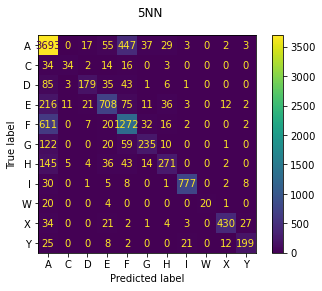


-------------- 10-NN WSZYSTKO ---------------
              precision    recall  f1-score   support

           A       0.70      0.88      0.78      4286
           C       0.88      0.07      0.13       103
           D       0.78      0.39      0.52       353
           E       0.75      0.59      0.66      1095
           F       0.63      0.59      0.61      1962
           G       0.68      0.50      0.57       447
           H       0.73      0.51      0.60       520
           I       0.94      0.91      0.92       832
           W       0.68      0.33      0.45        45
           X       0.93      0.79      0.85       522
           Y       0.84      0.67      0.75       267

    accuracy                           0.72     10432
   macro avg       0.78      0.57      0.62     10432
weighted avg       0.73      0.72      0.71     10432

-------------- NM WSZYSTKO ---------------
              precision    recall  f1-score   support

           A       0.68      0.26      0.3

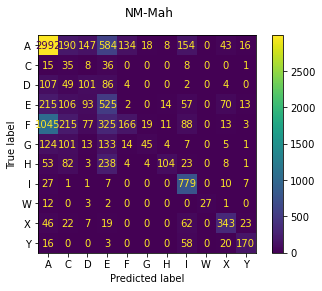

In [7]:
# Do testowania algorytmów zbiory są podzielone na testowy i treningowy za pomocą tego współczynnika; 
# testowy bedzie zawierał 1-(PARAM_SPLIT_TEST/1) części próbek oryginalego zbioru testowego;
# PARAM_SPLIT_TEST może także przyjąć wartość None sugerując użycie oryginalnego podziału na test i train;
PARAM_SPLIT_TEST = None # None 


"""
ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = [x for x in CLASS_NAMES if x != 'B'], # WSZYSTKIE KLASY
    limit_to_attributes = [ATTRIBUTE_NAMES[randint(0,len(ATTRIBUTE_NAMES))], ATTRIBUTE_NAMES[randint(0,len(ATTRIBUTE_NAMES))]],
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)
plot_2d(ds)
ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = [x for x in CLASS_NAMES if x != 'B'], # WSZYSTKIE KLASY
    limit_to_attributes = [ATTRIBUTE_NAMES[randint(0,len(ATTRIBUTE_NAMES))], ATTRIBUTE_NAMES[randint(0,len(ATTRIBUTE_NAMES))]],
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)
plot_2d(ds)
ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = [x for x in CLASS_NAMES if x != 'B'], # WSZYSTKIE KLASY
    limit_to_attributes = [ATTRIBUTE_NAMES[randint(0,len(ATTRIBUTE_NAMES))], ATTRIBUTE_NAMES[randint(0,len(ATTRIBUTE_NAMES))]],
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)
plot_2d(ds)
ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = [x for x in CLASS_NAMES if x != 'B'], # WSZYSTKIE KLASY
    limit_to_attributes = [ATTRIBUTE_NAMES[randint(0,len(ATTRIBUTE_NAMES))], ATTRIBUTE_NAMES[randint(0,len(ATTRIBUTE_NAMES))]],
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)
plot_2d(ds)



ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = ["D", "G"], 
    limit_to_attributes = 2,
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)
plot_2d(ds)

ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = ["A", "C"], 
    limit_to_attributes = 2,
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)
plot_2d(ds)



PARAM_SPLIT_TEST = None # None 
ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = ["D", "G", "H", "X"], 
    limit_to_attributes = 5,
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)
true, pred = ds.predict_test_samples(method="nm")
print("-------------- NM ---------------")
print(classification_report(true, pred))

true, pred = ds.predict_test_samples(method="mah-nm")
print("-------------- NM-Mah ---------------")
print(classification_report(true, pred))

true, pred = ds.predict_test_samples(method="knn", k=1)
print("-------------- 1-NN ---------------")
print(classification_report(true, pred))

true, pred = ds.predict_test_samples(method="knn", k=3)
print("-------------- 3-NN ---------------")
print(classification_report(true, pred))

true, pred = ds.predict_test_samples(method="knn", k=5)
print("-------------- 5-NN ---------------")
print(classification_report(true, pred))

true, pred = ds.predict_test_samples(method="knn", k=9)
print("-------------- 9-NN ---------------")
print(classification_report(true, pred))

ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = [x for x in CLASS_NAMES if x != 'B'], # WSZYSTKIE KLASY POZA B -> TWORZY MACIERZ OSOBLIWĄ
    limit_to_attributes = ATTRIBUTE_NAMES,
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)
true, pred = ds.predict_test_samples(method="knn", k=5)
print("-------------- 5-NN WSZYSTKO ---------------")
print(classification_report(true, pred))


"""
ds = Dataset(
    TRAIN_FILE_PATH, 
    TEST_FILE_PATH, 
    limit_to_classes = [x for x in CLASS_NAMES if x != 'B'], # WSZYSTKIE KLASY POZA B -> TWORZY MACIERZ OSOBLIWĄ
    limit_to_attributes = 10,
    train_test_split_ratio=PARAM_SPLIT_TEST, 
    normalize=False
)

true, pred = ds.predict_test_samples(method="knn", k=5)
print("-------------- 1-NN WSZYSTKO ---------------")
print(classification_report(true, pred))

true, pred = ds.predict_test_samples(method="knn", k=5)
print("-------------- 5-NN WSZYSTKO ---------------")
print(classification_report(true, pred))
# plot confusion matrix
fig, ax = plt.subplots()
fig.suptitle("5NN")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true, pred, labels=ds.preserved_classes), display_labels=ds.preserved_classes)
disp.plot(ax=fig.gca(), xticks_rotation=0)
plt.show()

print()


true, pred = ds.predict_test_samples(method="knn", k=10)
print("-------------- 10-NN WSZYSTKO ---------------")
print(classification_report(true, pred))

true, pred = ds.predict_test_samples(method="nm",)
print("-------------- NM WSZYSTKO ---------------")
print(classification_report(true, pred))

true, pred = ds.predict_test_samples(method="mah-nm")
print("-------------- NM-Mah WSZYSTKO ---------------")
print(classification_report(true, pred))
print(confusion_matrix(true, pred, labels=ds.preserved_classes))
fig, ax = plt.subplots()
fig.suptitle("NM-Mah")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true, pred, labels=ds.preserved_classes), display_labels=ds.preserved_classes)
disp.plot(ax=fig.gca(), xticks_rotation=0)
plt.show()